<a href="https://colab.research.google.com/github/sway-am/Interpretability-of-CNN/blob/main/LIMEandSHAP_ON_MNIST.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.datasets import mnist
from tensorflow.keras.utils import to_categorical

In [2]:
(x_train, y_train), (x_test, y_test) = mnist.load_data()
x_train = x_train.reshape((-1,28,28,1)).astype('float32') / 255.0
x_test = x_test.reshape((-1,28,28,1)).astype('float32') / 255.0

11490434/11490434 [==============================] - 0s 0us/step


In [3]:
import numpy as np
def to_rgb(x):
    x_rgb = np.zeros((x.shape[0], 28, 28, 3))
    for i in range(3):
        x_rgb[..., i] = x[..., 0]
    return x_rgb
x_train = to_rgb(x_train)
x_test = to_rgb(x_test)

In [4]:
from tensorflow import keras
from tensorflow.keras import layers

model = keras.Sequential([
    keras.Input(shape=(28, 28, 3)),
    layers.Conv2D(16, 3, activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(32, 3, activation='relu'),
    layers.MaxPooling2D(),
    layers.Flatten(),
    layers.Dense(10, activation='softmax')
])


In [5]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 26, 26, 16)        448       
                                                                 
 max_pooling2d (MaxPooling2  (None, 13, 13, 16)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 11, 11, 32)        4640      
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 5, 5, 32)          0         
 g2D)                                                            
                                                                 
 flatten (Flatten)           (None, 800)               0         
                                                                 
 dense (Dense)               (None, 10)                8

In [6]:
model.compile(
  loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
  optimizer=keras.optimizers.Adam(),
  metrics=['accuracy']
)

In [7]:
model.fit(
        x_train,
        y_train,
        epochs=2,
        batch_size=32,
        validation_data = (x_test, y_test))


Epoch 1/2


/usr/local/lib/python3.10/dist-packages/keras/src/backend.py:5729: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


1875/1875 [==============================] - 42s 21ms/step - loss: 0.1739 - accuracy: 0.9474 - val_loss: 0.0688 - val_accuracy: 0.9782
Epoch 2/2
1875/1875 [==============================] - 35s 19ms/step - loss: 0.0622 - accuracy: 0.9809 - val_loss: 0.0440 - val_accuracy: 0.9855


Using LIME

In [8]:
# explaning model with LIME

In [9]:
!pip install lime

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 275.7/275.7 kB 5.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for lime: filename=lime-0.2.0.1-py3-none-any.whl size=283835 sha256=f14dc7c056b8209781caa1566bc05b1b8058675fe317c0634f2ce833c6dc5640
  Stored in directory: /root/.cache/pip/wheels/fd/a2/af/9ac0a1a85a27f314a06b39e1f492bee1547d52549a4606ed89
Successfully built lime


In [10]:
import lime
from lime import lime_image
from skimage.segmentation import mark_boundaries
import matplotlib.pyplot as plt
import random

  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 [==============================] - 0s 34ms/step


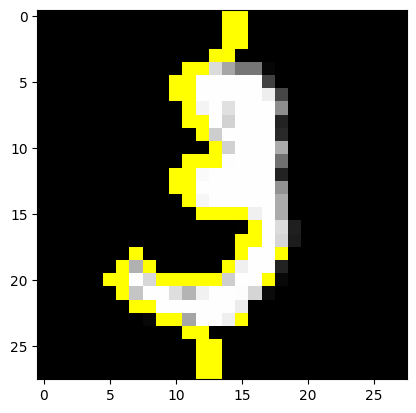

In [11]:
explainer = lime_image.LimeImageExplainer(random_state=42)
explanation = explainer.explain_instance(
         x_train[10],
         model.predict
)
plt.imshow(x_train[10])
image, mask = explanation.get_image_and_mask(
         model.predict(
              x_train[10].reshape((1,28,28,3))
         ).argmax(axis=1)[0],
         positive_only=True,
         hide_rest=False)
plt.imshow(mark_boundaries(image, mask))

  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 [==============================] - 0s 63ms/step


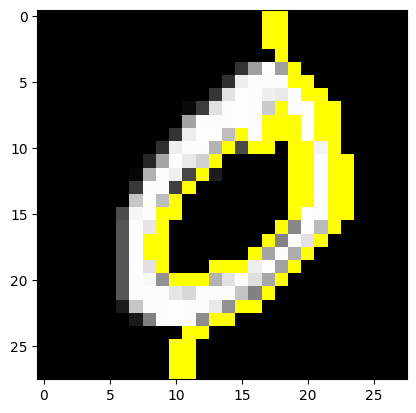

In [12]:
explainer = lime_image.LimeImageExplainer(random_state=42)
explanation = explainer.explain_instance(
         x_train[1],
         model.predict
)
plt.imshow(x_train[1])
image, mask = explanation.get_image_and_mask(
         model.predict(
              x_train[1].reshape((1,28,28,3))
         ).argmax(axis=1)[0],
         positive_only=True,
         hide_rest=False)
plt.imshow(mark_boundaries(image, mask))

Testing SHAP on CNN

In [14]:
!pip install shap

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 533.5/533.5 kB 5.7 MB/s eta 0:00:00


In [15]:
import shap
import numpy as np

In [38]:
# Assuming x_train is your training data
explainer = shap.Explainer(model, x_train)

In [39]:
x_test[0].shape

(28, 28, 3)

In [50]:
# select backgroud for shap
background = x_train[np.random.choice(x_train.shape[0], 100, replace=False)]


In [62]:
background.shape

(100, 28, 28, 3)

In [51]:
# DeepExplainer to explain predictions of the model
explainer = shap.DeepExplainer(model, background)


In [52]:
np.unique(y_test,return_counts=True)

(array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], dtype=uint8),
 array([ 980, 1135, 1032, 1010,  982,  892,  958, 1028,  974, 1009]))

In [53]:
# class label list
class_names = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
# example image for each class
images_dict = dict()
for i, l in enumerate(y_train):
  if len(images_dict)==10:
    break
  if l not in images_dict.keys():
    images_dict[l] = x_train[i].reshape((28, 28,3))
images_dict = dict(sorted(images_dict.items()))

# example image for each class for test set
x_test_dict = dict()
for i, l in enumerate(y_test):
  if len(x_test_dict)==10:
    break
  if l not in x_test_dict.keys():
    x_test_dict[l] = x_test[i]
# order by class
x_test_each_class = [x_test_dict[i] for i in sorted(x_test_dict)]
x_test_each_class = np.asarray(x_test_each_class)
# Compute predictions
predictions = model.predict(x_test_each_class)
predicted_class = np.argmax(predictions, axis=1)


1/1 [==============================] - 0s 25ms/step


In [54]:
# compute shap values
shap_values = explainer.shap_values(x_test_each_class)

In [59]:
x_test_each_class.shape

(10, 28, 28, 3)

In [55]:
# plot actual and predicted class
def plot_actual_predicted(images, pred_classes):
  fig, axes = plt.subplots(1, 11, figsize=(16, 15))
  axes = axes.flatten()

  # plot
  ax = axes[0]
  dummy_array = np.array([[[0, 0, 0, 0]]], dtype='uint8')
  ax.set_title("Base reference")
  ax.set_axis_off()
  ax.imshow(dummy_array, interpolation='nearest')
  # plot image
  for k,v in images.items():
    ax = axes[k+1]
    ax.imshow(v, cmap=plt.cm.binary)
    ax.set_title(f"True: %s \nPredict: %s" % (class_names[k], class_names[pred_classes[k]]))
    ax.set_axis_off()
  plt.tight_layout()
  plt.show()

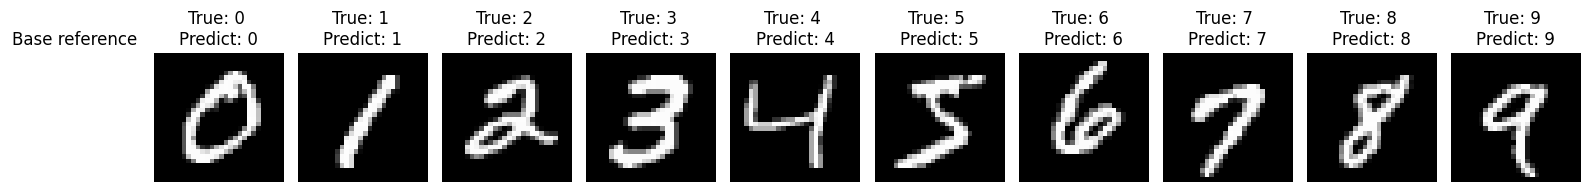

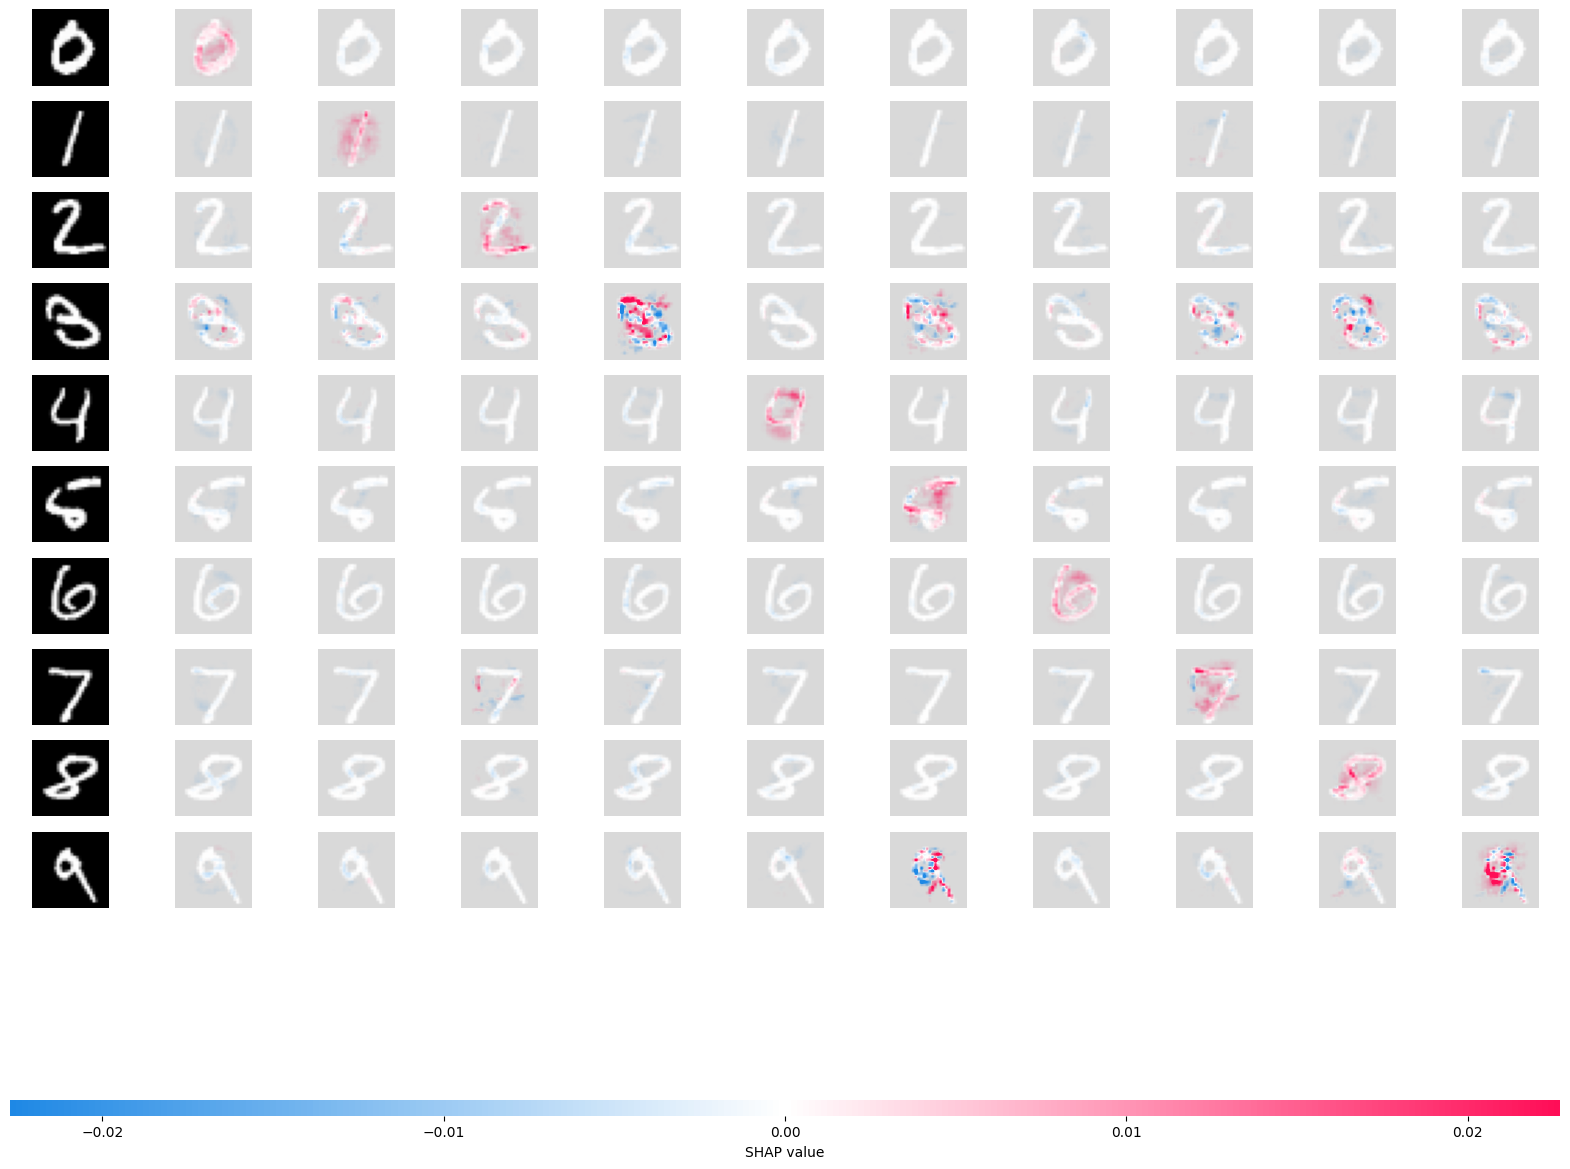

In [56]:
# plot SHAP values
plot_actual_predicted(images_dict, predicted_class)
print()
shap.image_plot(shap_values, x_test_each_class)

In [80]:
# Example image for the first class in the test set
x_test_example = x_test[0].reshape((1, 28, 28, 3))


In [81]:
# Compute predictions for the example
predictions_example = model.predict(x_test_example)

1/1 [==============================] - 0s 22ms/step


In [82]:
# Compute SHAP values for the example
shap_values_example = explainer.shap_values(x_test_example)

# Print the predicted class for the example
predicted_class_example = np.argmax(predictions_example, axis=1)
print(f"Predicted Class: {predicted_class_example[0]}")



Predicted Class: 7


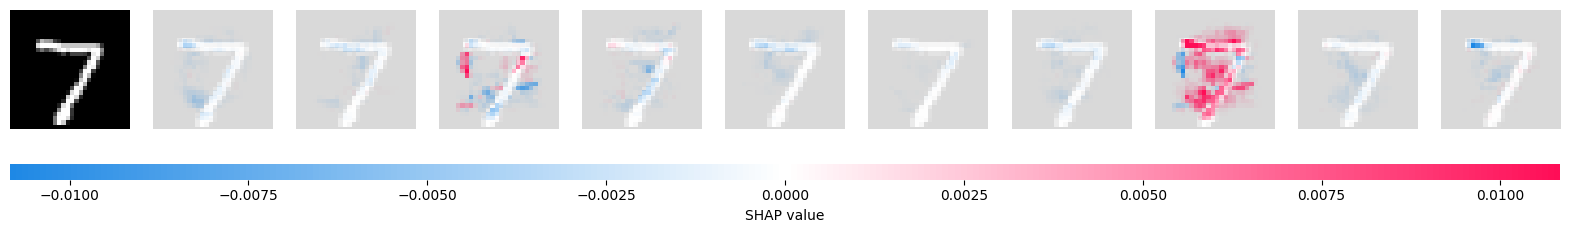

In [83]:
# Plot the SHAP values over the image
shap.image_plot(shap_values_example, x_test_example)
# Show the plot
plt.show()